### 1. Carregar os Dados Processados (X e y) do PC

In [ ]:
# Importa as bibliotecas necessárias para esta etapa.
import numpy as np
import os

# --- Carregar os Dados Processados do Ambiente ---
# Define os nomes dos ficheiros que já estão no ambiente do Colab.
x_file = 'X_processed.npy'
y_file = 'y_processed.npy'

# Verifica se os ficheiros realmente existem antes de tentar carregá-los.
if os.path.exists(x_file) and os.path.exists(y_file):
    # Carrega os arrays X (features) e y (alvo) a partir dos ficheiros .npy.
    # Usamos allow_pickle=True por segurança, caso o NumPy o exija.
    X = np.load(x_file, allow_pickle=True)
    y = np.load(y_file, allow_pickle=True)

    print("Dados de treino (X e y) carregados com sucesso do ambiente Colab!")
    print(f"Formato das features (X): {X.shape}")
    print(f"Formato do alvo (y): {y.shape}")
else:
    print(f"\nERRO: O ficheiro '{x_file}' ou '{y_file}' não foi encontrado no ambiente.")
    print("Por favor, certifique-se de que fez o upload de ambos os ficheiros para esta sessão.")

Dados de treino (X e y) carregados com sucesso do ambiente Colab!
Formato das features (X): (10000, 7)
Formato do alvo (y): (10000,)


### 2. Criar Sequências e Dividir em Treino/Teste

In [ ]:
# Importa as bibliotecas necessárias do TensorFlow e Scikit-learn.
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

print("A preparar os dados em sequências para o modelo LSTM...")

# --- Criação das Sequências ---
# Vamos definir que o modelo irá olhar para os últimos 50 registos de sensores
# para prever se haverá uma falha no último registo.
sequence_length = 50

X_sequences = []
y_sequences = []

# Este loop cria as "janelas deslizantes"
for i in range(len(X) - sequence_length + 1):
    # Pega numa sequência de 50 registos de X
    X_sequences.append(X[i:i + sequence_length])
    # A etiqueta (y) para esta sequência é o valor 'Target' no final da janela
    y_sequences.append(y[i + sequence_length - 1])

# Converte as listas para arrays NumPy.
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# --- CORREÇÃO: GARANTIR O TIPO DE DADOS CORRETO ---
# Convertemos explicitamente os nossos dados para float32, que é o tipo que o TensorFlow espera.
X_sequences = X_sequences.astype('float32')
y_sequences = y_sequences.astype('float32')


# --- Divisão em Treino e Teste ---
# Agora, dividimos as nossas novas sequências em conjuntos de treino e teste.
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences
)

print("\nDados preparados e divididos com sucesso!")
print(f"Formato dos dados de treino (X_train): {X_train.shape}")
print(f"Formato dos dados de teste (X_test): {X_test.shape}")
print(f"  -> Temos {X_train.shape[0]} sequências para treino.")
print(f"  -> Cada sequência tem {X_train.shape[1]} passos no tempo (timesteps).")
print(f"  -> Cada passo no tempo tem {X_train.shape[2]} leituras de sensores (features).")

A preparar os dados em sequências para o modelo LSTM...

Dados preparados e divididos com sucesso!
Formato dos dados de treino (X_train): (7960, 50, 7)
Formato dos dados de teste (X_test): (1991, 50, 7)
  -> Temos 7960 sequências para treino.
  -> Cada sequência tem 50 passos no tempo (timesteps).
  -> Cada passo no tempo tem 7 leituras de sensores (features).


### 3. Criei o modelo

In [ ]:
# Importa as bibliotecas necessárias que podem ter sido esquecidas
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define a arquitetura do nosso modelo LSTM usando a API Sequential do Keras.
model = Sequential([
    # 1. A primeira camada é a LSTM.
    #    - 64 é o número de "neurónios" ou unidades de memória na camada.
    #    - input_shape define o formato de uma única amostra: (50 timesteps, 7 features).
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),

    # 2. A camada Dropout "desliga" aleatoriamente 20% dos neurónios durante o treino
    #    para ajudar a prevenir o overfitting.
    Dropout(0.2),

    # 3. A camada de saída é uma camada Densa com 1 neurónio e ativação 'sigmoid',
    #    perfeita para uma previsão de falha (0 ou 1).
    Dense(1, activation='sigmoid')
])

# Compila o modelo, definindo o otimizador, a função de perda e a métrica.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Imprime um resumo da arquitetura do modelo.
model.summary()

print("\nArquitetura do modelo LSTM criada e compilada com sucesso!")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,497 (72.25 KB)

 Trainable params: 18,497 (72.25 KB)

 Non-trainable params: 0 (0.00 B)


Arquitetura do modelo LSTM criada e compilada com sucesso!


### 4. Treinar o Modelo e Guardar os Resultados

Iniciando o treinamento do modelo LSTM...
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9406 - loss: 0.2371 - val_accuracy: 0.9221 - val_loss: 0.2184
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9446 - loss: 0.2243 - val_accuracy: 0.9297 - val_loss: 0.1913
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9509 - loss: 0.1748 - val_accuracy: 0.9216 - val_loss: 0.2165
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9501 - loss: 0.1935 - val_accuracy: 0.9432 - val_loss: 0.1686
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9502 - loss: 0.1779 - val_accuracy: 0.9131 - val_loss: 0.2281
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9402 - loss: 0.2234 - val_accuracy: 0.9277 - val_loss: 0.1981
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9544 - loss: 0.1847 - val_accuracy: 0.9453 - val_loss: 0.1556
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - 

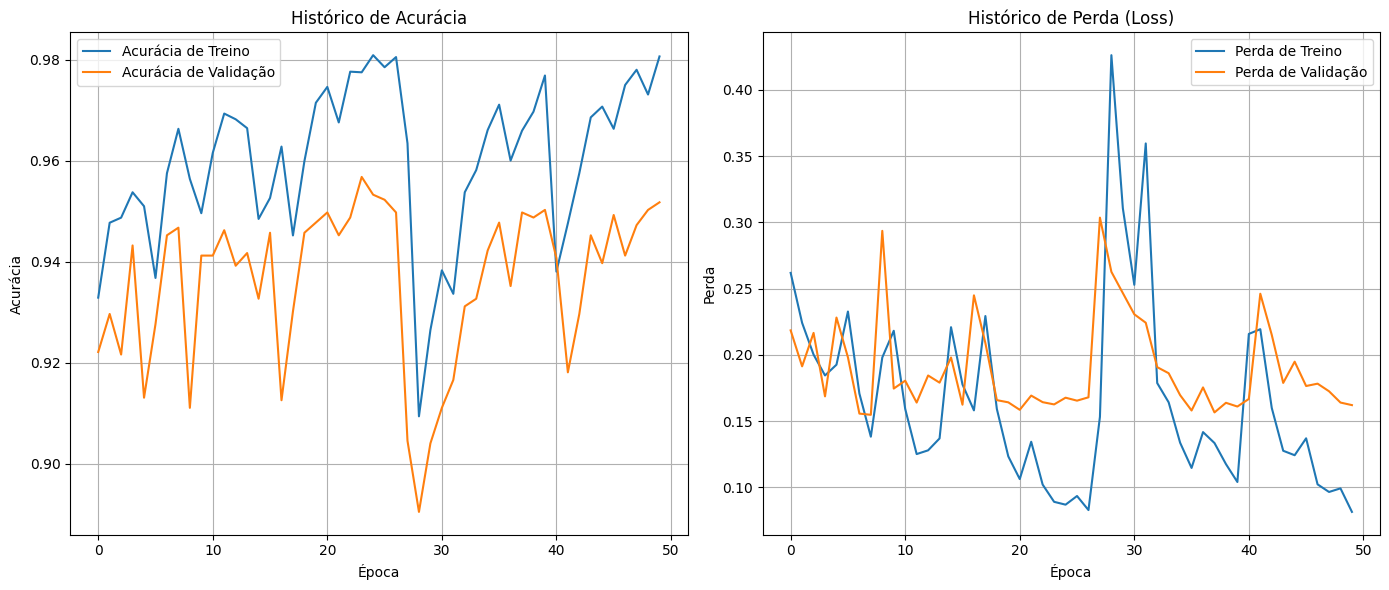


Salvando os resultados do treinamento em um arquivo JSON...

Resumo do treinamento salvo com sucesso em: training_summary.json
Pode agora fazer o download deste ficheiro a partir do painel de ficheiros à esquerda.


In [ ]:
# Importa as bibliotecas necessárias para visualização e para guardar o ficheiro JSON.
import matplotlib.pyplot as plt
import json
import pandas as pd
import os # Importamos 'os' para uma boa prática, embora não seja estritamente necessário aqui.

# --- 1. Parâmetros do Treino ---
EPOCHS = 50
BATCH_SIZE = 64

# --- 2. Treinar o Modelo ---
print("Iniciando o treinamento do modelo LSTM...")

# A função .fit() inicia o treino e retorna um objeto 'history'.
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    class_weight={0: 1., 1: (len(y_train) - sum(y_train)) / sum(y_train)},
    verbose=1
)

print("\nTreinamento concluído!")

# --- 3. Avaliar o Modelo ---
print("\nAvaliando o modelo no conjunto de teste...")
final_loss, final_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"\nAcurácia final no teste: {final_accuracy * 100:.2f}%")
print(f"Perda final no teste: {final_loss:.4f}")

# --- 4. Visualizar o Histórico de Treinamento ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Histórico de Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Histórico de Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 5. Salvar os Artefatos em JSON ---
print("\nSalvando os resultados do treinamento em um arquivo JSON...")

# Converte o objeto history para um dicionário de listas.
history_dict = pd.DataFrame(history.history).to_dict('list')

# Cria um dicionário com todas as informações pertinentes.
training_summary = {
    "model_architecture": "Single Layer LSTM",
    "training_parameters": {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "sequence_length": X_train.shape[1]
    },
    "dataset_info": {
        "training_samples": X_train.shape[0],
        "testing_samples": X_test.shape[0],
        "features_per_timestep": X_train.shape[2]
    },
    "training_history": history_dict,
    "final_evaluation": {
        "test_loss": final_loss,
        "test_accuracy": final_accuracy
    }
}

# --- A CORREÇÃO ESTÁ AQUI ---
# Em vez de usar 'drive_project_path', guardamos o ficheiro diretamente no ambiente local.
json_path = 'training_summary.json'

# Salva o dicionário como um arquivo JSON.
with open(json_path, 'w') as f:
    json.dump(training_summary, f, indent=4)

print(f"\nResumo do treinamento salvo com sucesso em: {json_path}")
print("Pode agora fazer o download deste ficheiro a partir do painel de ficheiros à esquerda.")

### 5. Guardar o Modelo Final Treinado

In [ ]:
# Define o nome do ficheiro onde o modelo será guardado.
model_path = 'predictive_maintenance_model.keras'

print(f"A guardar o modelo treinado em: {model_path}...")

# A função .save() guarda a arquitetura, os pesos e o estado do otimizador do modelo.
# A variável 'model' foi criada e treinada nas células anteriores.
model.save(model_path)

print(f"\n--- SUCESSO! ---")
print(f"Modelo guardado com sucesso em: '{model_path}'")

A guardar o modelo treinado em: predictive_maintenance_model.keras...

--- SUCESSO! ---
Modelo guardado com sucesso em: 'predictive_maintenance_model.keras'
